# Time Series Prediction Using LSTM and CNN

In [13]:
#importing necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data can be downloaded from: http://archive.ics.uci.edu/ml/machine-learning-databases/00235/
# Open the zip file and grab the file 'household_power_consumption.txt' put it in the directory 
# that you would like to run the code. 

df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
# Printing initial 5 values
df.head() 

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [4]:
# information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [5]:
# total values present
df.shape

(2075259, 7)

In [6]:
df.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

In [7]:
## finding all columns that have nan:

droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [8]:
# filling nan with mean in any columns

for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [9]:
# another sanity check to make sure that there are not more any nan

df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [10]:
# resampling of data over hour

df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [16]:
# helper function for plotting charts

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

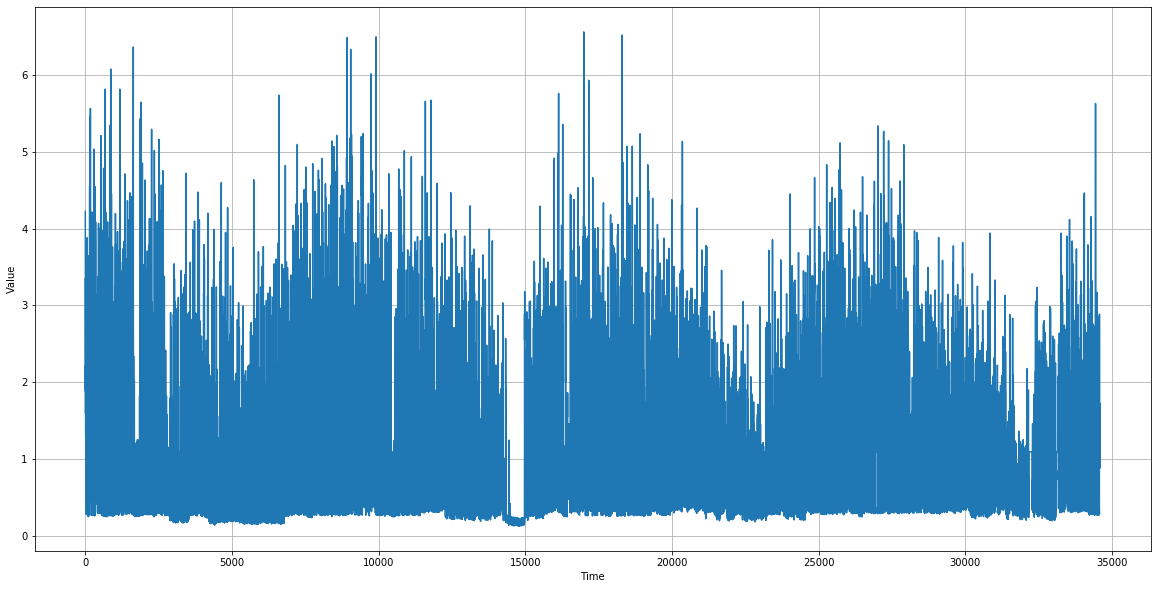

In [17]:
# plotting data and creating numpy arrays from it

time_step = []
vals = []

step=0
for row in df_resample['Global_active_power']:
    vals.append(float(row))
    time_step.append(step)
    step = step + 1

series = np.array(vals)
time = np.array(time_step)
plt.figure(figsize=(20, 10))
plot_series(time, series)

In [19]:
#splitting the data

split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# setting up constants

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [20]:
# helper function to turn data into window dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
# funtion for predicting result

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [22]:
import tensorflow as tf

In [23]:
# running the code for 100 epochs to find optimal learning rate

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 1s 95ms/step - loss: 3.0102 - mae: 3.4765 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 53ms/step - loss: 2.9795 - mae: 3.4452 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 46ms/step - loss: 2.9367 - mae: 3.4015 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 40ms/step - loss: 2.8918 - mae: 3.3556 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 56ms/step - loss: 2.8487 - mae: 3.3118 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 44ms/step - loss: 2.8086 - mae: 3.2712 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 49ms/step - loss: 2.7730 - mae: 3.2352 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 59ms/step - loss: 2.7418 - mae: 3.2037 - lr: 2.2387e-08
Ep

10/10 [==============================] - 0s 46ms/step - loss: 1.2535 - mae: 1.6915 - lr: 3.5481e-05
Epoch 73/100
10/10 [==============================] - 0s 48ms/step - loss: 0.9881 - mae: 1.4192 - lr: 3.9811e-05
Epoch 74/100
10/10 [==============================] - 1s 55ms/step - loss: 1.0533 - mae: 1.4874 - lr: 4.4668e-05
Epoch 75/100
10/10 [==============================] - 0s 44ms/step - loss: 1.1729 - mae: 1.6044 - lr: 5.0119e-05
Epoch 76/100
10/10 [==============================] - 0s 48ms/step - loss: 2.0492 - mae: 2.4998 - lr: 5.6234e-05
Epoch 77/100
10/10 [==============================] - 0s 49ms/step - loss: 4.8608 - mae: 5.3297 - lr: 6.3096e-05
Epoch 78/100
10/10 [==============================] - 0s 47ms/step - loss: 6.6750 - mae: 7.1559 - lr: 7.0795e-05
Epoch 79/100
10/10 [==============================] - 0s 47ms/step - loss: 12.1420 - mae: 12.6316 - lr: 7.9433e-05
Epoch 80/100
10/10 [==============================] - 0s 46ms/step - loss: 8.9131 - mae: 9.3994 - lr: 8.912

[1e-08, 0.0001, 0, 60]

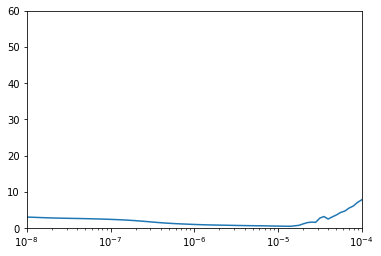

In [77]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [86]:
# now running code for 200 epochs with optimal learning rate found in previous step

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)

Epoch 1/200
25/25 [==============================] - 0s 19ms/step - loss: 3.6688 - mae: 4.1458
Epoch 2/200
25/25 [==============================] - 0s 16ms/step - loss: 1.1627 - mae: 1.5960
Epoch 3/200
25/25 [==============================] - 0s 17ms/step - loss: 0.6757 - mae: 1.0732
Epoch 4/200
25/25 [==============================] - 0s 16ms/step - loss: 0.5525 - mae: 0.9368
Epoch 5/200
25/25 [==============================] - 0s 16ms/step - loss: 0.5050 - mae: 0.8803
Epoch 6/200
25/25 [==============================] - 0s 15ms/step - loss: 0.4681 - mae: 0.8349
Epoch 7/200
25/25 [==============================] - 0s 16ms/step - loss: 0.4465 - mae: 0.8097
Epoch 8/200
25/25 [==============================] - 0s 16ms/step - loss: 0.4309 - mae: 0.7910
Epoch 9/200
25/25 [==============================] - 0s 16ms/step - loss: 0.4142 - mae: 0.7710
Epoch 10/200
25/25 [==============================] - 0s 16ms/step - loss: 0.4056 - mae: 0.7614
Epoch 11/200
25/25 [=============================

25/25 [==============================] - 0s 19ms/step - loss: 0.2633 - mae: 0.5724
Epoch 87/200
25/25 [==============================] - 0s 19ms/step - loss: 0.2623 - mae: 0.5709
Epoch 88/200
25/25 [==============================] - 0s 19ms/step - loss: 0.2620 - mae: 0.5703
Epoch 89/200
25/25 [==============================] - 0s 19ms/step - loss: 0.2641 - mae: 0.5734
Epoch 90/200
25/25 [==============================] - 0s 19ms/step - loss: 0.2619 - mae: 0.5707
Epoch 91/200
25/25 [==============================] - 0s 19ms/step - loss: 0.2609 - mae: 0.5687
Epoch 92/200
25/25 [==============================] - 0s 19ms/step - loss: 0.2602 - mae: 0.5676
Epoch 93/200
25/25 [==============================] - 0s 19ms/step - loss: 0.2598 - mae: 0.5674
Epoch 94/200
25/25 [==============================] - 0s 19ms/step - loss: 0.2596 - mae: 0.5672
Epoch 95/200
25/25 [==============================] - 0s 20ms/step - loss: 0.2607 - mae: 0.5678: 0s - loss: 0.2613 - mae: 0.56
Epoch 96/200
25/25 [==

25/25 [==============================] - ETA: 0s - loss: 0.2368 - mae: 0.531 - 1s 24ms/step - loss: 0.2368 - mae: 0.5315
Epoch 171/200
25/25 [==============================] - 1s 25ms/step - loss: 0.2385 - mae: 0.5349
Epoch 172/200
25/25 [==============================] - 1s 24ms/step - loss: 0.2377 - mae: 0.5331
Epoch 173/200
25/25 [==============================] - 1s 23ms/step - loss: 0.2380 - mae: 0.5337
Epoch 174/200
25/25 [==============================] - 1s 23ms/step - loss: 0.2366 - mae: 0.5311
Epoch 175/200
25/25 [==============================] - 1s 24ms/step - loss: 0.2374 - mae: 0.5328
Epoch 176/200
25/25 [==============================] - 1s 23ms/step - loss: 0.2425 - mae: 0.5426
Epoch 177/200
25/25 [==============================] - 1s 23ms/step - loss: 0.2455 - mae: 0.5456
Epoch 178/200
25/25 [==============================] - 1s 23ms/step - loss: 0.2368 - mae: 0.5321
Epoch 179/200
25/25 [==============================] - 1s 24ms/step - loss: 0.2366 - mae: 0.5313
Epoch 

In [87]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

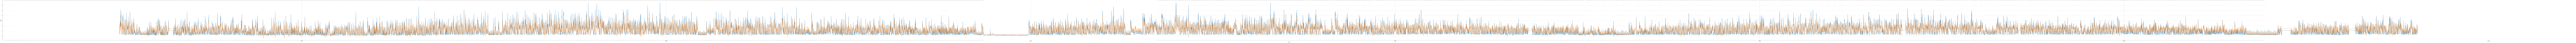

In [92]:
# plotting result

plt.figure(figsize=(625,10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [89]:
# calculating mean absolute error

tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.47758633